In [1]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets

class warper:
    
    def __init__(self):
        a = 0
        self.orig_data = []
        self.transformed_data = []
        self.original_separator = []
        self.transformed_separator = []
        self.labels = []
        self.ind0 = []
        self.ind1 = []
        self.grid = []
        
    # define the user-defined transformation in numpy
    def define_rule(self,rule1,rule2):
        self.rule1 = lambdify((x1,x2),rule1,np)
        self.rule2 = lambdify((x1,x2),rule2,np)

    # transform data bsaed on user-defined transformations
    def make_rule(self,data):
        s = data[:,0]
        t = data[:,1]

        ## transform space - each axes - via net transform    
        f1 = self.rule1(s,t)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f2 = self.rule2(s,t)
        f2.shape = (len(f2),1)

        return f1,f2
    
    # create points based on user-defined transformations
    def make_pts(self):
        # generate datapoints based on user-defined rule
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)

        # cut the space to make this rule
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        ## build dataset based on this rule
        num_pts = 200   # number of points for dataset
        X = -5 + 10*np.random.rand(num_pts,2)
        g1,g2 = self.make_rule(X)
        pts = g1 + g2

        ind0 = np.argwhere(pts <= 0)
        ind0 = [v[0] for v in ind0]
        ind1 = np.argwhere(pts > 0)
        ind1 = [v[0] for v in ind1]

        y = np.zeros((num_pts,1))
        y[ind0] = -1
        y[ind1] = 1

        # form transformed dataset
        T = np.concatenate((g1,g2),axis = 1)

        # store original and transformed data
        self.orig_data = X
        self.transformed_data = T
        self.labels = y
        self.ind0 = ind0
        self.ind1 = ind1
        
        # now that points are stored, we can make a warpable grid
        self.make_warpable_grid()

    # make the adjustable grid
    def make_warpable_grid(self):
        # define range of grid
        horz_max = max(max(self.orig_data[:,0]),max(self.transformed_data[:,0]))
        horz_min = min(min(self.orig_data[:,0]),min(self.transformed_data[:,0]))
        
        vert_max = max(max(self.transformed_data[:,1]),max(self.transformed_data[:,1]))
        vert_min = min(min(self.orig_data[:,1]),min(self.transformed_data[:,1]))
        
        s = np.linspace(-10,10,40)
        s.shape = (len(s),1)
        g = np.array([-10,-10])
        g.shape = (1,len(g))
        e = np.linspace(-10,10,200)
        e.shape = (len(e),1)
        f = np.ones((200,1))
        f.shape = (len(f),1)
        for a in s:
            t = a*f
            h = np.concatenate((e,t),axis = 1)
            i = np.concatenate((t,e),axis = 1)
            j = np.concatenate((h,i),axis = 0)
            g = np.concatenate((g,j),axis = 0)

        self.grid = g[1:,:]
        
    # plot the before data, separator, and grid
    def show_before_picture(self):
        # make figure
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)          # panel for original space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])

        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        ax1.axis('off')
        
    # create the figure 
    def show_before_and_after(self):
        # make figure
        fig = plt.figure(figsize = (10,5))
        ax1 = fig.add_subplot(121)          # panel for original space
        ax2 = fig.add_subplot(122)          # panel transformed space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])
        ax1.axis('off')
        
        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        
        ### plot transformed data and separator
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        self.plot_separator(f1,f2,z,ax2)
        self.plot_pts(self.transformed_data,ax2)
        
        # plot grid        
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
        self.plot_grid(grid2,ax2)
        T = self.transformed_data
        hgap = (max(T[:,0]) - min(T[:,0]))*0.05
        vgap = (max(T[:,1]) - min(T[:,1]))*0.05
        ax2.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
        ax2.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
        ax2.axis('off')
        
    # plot current separator
    def plot_separator(self,x,y,z,ax):
        # plot rule in original and transformed spaces
        ax.contour(x,y,z,colors='k', linewidths=2.0,levels = [0],zorder = 2)
        
    # plot points
    def plot_pts(self,data,ax):
        # custom colors
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        
        # plot points on desired panel
        ax.scatter(data[self.ind0,0],data[self.ind0,1],s = 50, color = green, edgecolor = 'k')
        ax.scatter(data[self.ind1,0],data[self.ind1,1],s = 50, color = red, edgecolor = 'k')

    # plot adjustble grid
    def plot_grid(self,grid,ax):
        for i in range(80):
            ax.plot(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 0)   
        
    # show the net transformation using slider
    def transformation_slider(self):  
        
        # make points start and end
        X1 = self.orig_data
        X2 = self.transformed_data
        
        # make separator start and end
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        
        # make grid start and end 
        grid1 = self.grid
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
            
        def show_fit(p):
            # make figure
            fig = plt.figure(figsize = (5,5))
            ax1 = fig.add_subplot(111)          # panel for original space
            ax1.axis('off')
   
            # make alpha
            alpha = p/float(300)

            # setup current points and print
            T = (1-alpha)*X1 + alpha*X2
            self.plot_pts(T,ax1)
            
            # setup separator and print
            sep1 = (1-alpha)*s + alpha*f1
            sep2 = (1-alpha)*t + alpha*f2
            self.plot_separator(sep1,sep2,z,ax1)
            
            # setup current grid and print
            grid = (1-alpha)*grid1 + alpha*grid2
            self.plot_grid(grid,ax1)
            
            # set axis limits for current dataset
            hgap = (max(T[:,0]) - min(T[:,0]))*0.05
            vgap = (max(T[:,1]) - min(T[:,1]))*0.05
            ax1.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
            ax1.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
                               
        interact(show_fit, p=widgets.IntSlider(min=0,max=300,step=1,value=0))

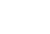

In [72]:
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(-10.1,10.1,2000)
s,t = np.meshgrid(r,r)

# plot this EXTREMELY small - hack around the fact that you have to actually produce the plot to get the contour
fig = plt.figure(figsize = (0.02,0.02));  # looks like this is as small as you can make the figure without throwing an error, figsize dimensinos can be as small as 0.02 it seems
ax = fig.add_subplot(111);        # panel for original space
ax.axis('off');

# loop over
data = []
contours = []
for i in np.linspace(1,100,200):
    z = s*s + t*t -i
    # to get each contour we must - it seems - actually plot it.  So we plot it completely transparent, and with no axis
    c = ax.contour(s,t,z,colors='k', linewidths=2.0,levels = [0],alpha=0.0)  
    
    # grab points of contour
    p = c.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    x.shape = (len(x),1)
    y = v[:,1]
    y.shape = (len(y),1)
    data = np.concatenate((x,y),axis = 1)
    
#     fig = plt.figure(figsize = (5,5));
#     ax = fig.add_subplot(111);        # panel for original space
#     ax.plot(data[:,0],data[:,1])
    
    contours.append(data)

In [82]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

# create figure
p = figure(title="warp it", plot_height=400, plot_width=400, x_range = (-5,5),y_range=(-5,5))

# initialize properties of figure
p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# initialize contour
data = contours[0]
x = data[:,0]
y = data[:,1]
r = p.line(x, y, color="#2222aa", line_width=3)

# initialize scatter
d = 10*np.random.rand(10,2) - 5
q = p.circle(d[:,0],d[:,1])

# update func
def update(f, w=0):
    # update contour
    data = contours[w]
    x = data[:,0]
    y = data[:,1]
    r.data_source.data = dict(x=x, y=y)    
    
    # update scatter
    d = 10*np.random.rand(10,2) - 5
    x = d[:,0]
    y = d[:,1]
    q.data_source.data = dict(x=x, y=y) 
    
    # update figure range
    p.x_range.start = -5 
    p.x_range.end = 5
    p.y_range.start = -5
    p.y_range.end = 5
    
    # obligatory line to plot in notevook
    push_notebook()
    
show(p, notebook_handle=True)

Loading BokehJS ...

In [83]:
interact(update, f=["sin"], w=(0,100,1))